In [1]:
using Revise
using MPSTime
using JLD2
using Distributed
using Optimization
# using OptimizationBBO
using Random
using StatsBase
using Plots

In [25]:
function map_to_pm(windows, pms)
    l = maximum(vcat(windows...))
    inds = [ argmin(abs.(pms .- length(w)/l*100)) for w in windows]
    return pms[inds]
end

function sort_by_pms(results, windows, pms)
    percs = map_to_pm(windows, pms)
    res_by_pm = []
    for pm in pms
        push!(res_by_pm, results[percs .== pm])
    end
    return res_by_pm
end

function sort_by_pms(fold, pms)

    return sort_by_pms(fold["loss"], fold["eval_windows"], pms)
end

function loss_by_pm(res, pms; scale::Float64 = 1.)
    losses = map(f -> sort_by_pms(f, pms) ./ scale, res) 
    # return mapreduce(f -> sort_by_pms(f, pms), +, res) / length(res)
    pm_mean = [mean.(l) for l in losses]
    return mean(losses), std(hcat(pm_mean...); dims=2)

end

function mmae_std_by_pm(res, pms; scale::Float64 = 1.)
    mean_by_pm, std_by_pm = loss_by_pm(res, pms; scale=scale)

    return mean.(mean_by_pm), std_by_pm
end

mmae_std_by_pm (generic function with 1 method)

In [3]:

# using OptimizationMetaheuristics
# using OptimizationOptimJL
# using OptimizationNLopt
# using OptimizationOptimisers
# inst = parse(Int, ARGS[1])

Random.seed!(1)

params = (
    eta=(-3,log10(0.5)), 
    d=(5,15), 
    chi_max=(20,40)
) 
inst = 1


@load "kepler_windows_julia_idx_bck.jld2" windows_per_percentage
# windows_julia = windows_per_percentage
eval_windows = reduce(vcat, values(windows_per_percentage))


rs_f = jldopen("c4_folds_per_inst.jld2", "r");
    folds = read(rs_f, "folds")[inst];
    Xs = read(rs_f, "Xs_per_inst")[inst];
close(rs_f)
ys = ones(Int, size(Xs, 1));

tr_inds, te_inds = folds[1]
X_train, X_test = Xs[tr_inds,:], Xs[te_inds,:]



([2.99002455339537e-6 8.60607329732366e-5 … -1.94887499349594e-5 -1.85129663039518e-5; -1.81322881454005e-5 -2.16414987321834e-5 … -3.90373906777874e-5 -3.96271935294568e-5; … ; 2.36125826407196e-5 -1.38935959421715e-5 … 1.48851850029219e-5 -7.27032843395037e-6; 2.68257887853229e-5 -4.62341117346554e-6 … -2.44459908285144e-5 -1.57729236096582e-5], [-5.5014499866779e-6 -4.53792799759434e-6 … -1.58629023558343e-5 2.19382159724058e-5; 5.01632885567815e-5 -4.31655819177479e-6 … 1.02909153374409e-5 1.67050048514028e-5])

In [4]:
X_train

41×100 Matrix{Float64}:
  2.99002e-6   8.60607e-5  -3.9232e-5   …  -1.94887e-5  -1.8513e-5
 -1.81323e-5  -2.16415e-5  -2.16415e-5     -3.90374e-5  -3.96272e-5
 -2.69369e-5  -1.34431e-5  -1.34431e-5     -9.69982e-7  -7.19455e-5
 -4.99539e-6  -2.88248e-5  -4.79067e-6     -1.5179e-5   -8.97818e-6
  9.74413e-6  -2.21187e-5  -9.72748e-7      7.68383e-6  -1.761e-5
 -9.00526e-6  -1.81976e-5   1.00359e-6  …  -3.54804e-6   5.79597e-7
  4.26712e-5  -2.41644e-5   7.37677e-6      2.51709e-5   2.70258e-6
 -1.08978e-5   3.06224e-5  -1.13948e-5     -1.79548e-5  -2.27946e-5
 -1.93102e-5  -1.22096e-5  -6.10986e-5      1.37964e-5  -6.79975e-6
 -3.76655e-6  -1.26888e-5  -1.03876e-5      2.50467e-5  -1.97492e-5
  ⋮                                     ⋱               
  2.19143e-5  -2.70785e-5   2.779e-5        2.79592e-6   1.81173e-5
 -6.91445e-5  -3.07786e-5   3.01457e-5      1.40525e-5  -5.05485e-5
  4.34599e-5   1.08004e-5   4.35021e-5      2.34971e-5  -4.1341e-6
 -1.35994e-5   3.04517e-6  -9.21791e-6 

In [32]:
@load "KC4_rand_250_ns.jld2" res
res_r250_c4 = copy(res) |> values |> collect
pms = 5:10:95

mmae_c4_1, std_c4_1 = mmae_std_by_pm(res_r250_c4, pms)


┌ Warning: saved type MPSOptions is missing field svd_alg in workspace type; reconstructing
└ @ JLD2 /home/noodles/.julia/packages/JLD2/OP0XX/src/data/reconstructing_datatypes.jl:195


([2.5366780082853755e-5, 2.4374052433442107e-5, 2.406543738071461e-5, 2.40364674465117e-5, 2.4150941193176846e-5, 2.413789856954238e-5, 2.4149850995187755e-5, 2.4016799520802013e-5, 2.3920669132291776e-5, 2.3872787389885716e-5], [1.6936129477288325e-6; 1.2212146327360096e-6; … ; 1.1701182882531471e-6; 1.1695213762758175e-6;;])

In [6]:
println("d: ",res[1]["opts"].d, "\nChi_max: ",res[1]["opts"].chi_max, "\neta: ",res[1]["opts"].eta)

d: 5
Chi_max: 20
eta: 0.0019618210858353864


In [15]:
opts_re = res[1]["opts"]
properties = propertynames(opts_re)

opts = MPSOptions(; [field => getproperty(opts_re,field) for field in properties]...)
mps, _... = fitMPS(X_train, opts);
imp = init_imputation_problem(mps, X_test; verbosity=-10);


In [17]:
impute_sites = eval_windows[139]
method=:median
class = 0
inst = 1
imputed, errs, targets, stats, plots = MPS_impute(imp, class, inst, impute_sites, method; NN_baseline=true, plot_fits=true)

display(stats)
plot(plots...)

UndefVarError: UndefVarError: `flatBaseline` not defined in `MPSTime`
Suggestion: check for spelling errors or missing imports.

1-element Vector{Any}:
 Dict(:MAE => 2.4036827940829253e-5, :MAPE => 7.025527848550078, :NN_MAE => 3.41189418807294e-5, :NN_MAPE => 17.94847686578108)

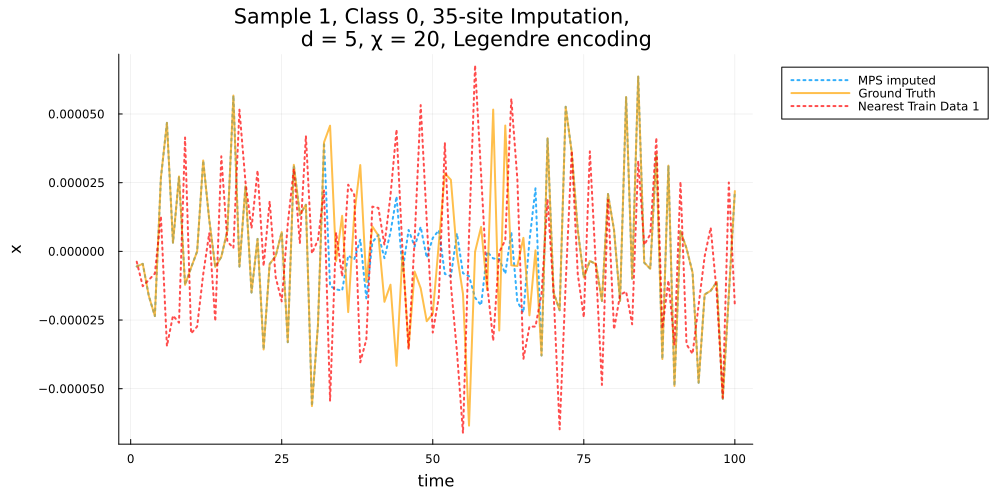

In [20]:
impute_sites = eval_windows[120]
method=:median
class = 0
inst = 1
imputed, errs, targets, stats, plots = MPS_impute(imp, class, inst, impute_sites, method; NN_baseline=true, plot_fits=true)

display(stats)
plot(plots...)

In [41]:
loss_dumb = []
# loss_median = mean(MPSTime.eval_loss(ImputationLoss(), mps, X_test, [0,0], eval_windows) )

opts_re = res[1]["opts"]
properties = propertynames(opts_re)

for fold in folds
    tr_inds, te_inds = fold
    X_train, X_test = Xs[tr_inds,:], Xs[te_inds,:]

    imp = init_imputation_problem(mps, X_test; verbosity=-10);

    # loss_nn = mean(MPSTime.eval_loss(ImputationLoss(), mps, X_test, [0,0], eval_windows, method=:kNearestNeighbour) )
    push!(loss_dumb, Dict("eval_windows"=>eval_windows,
                          "loss"=>MPSTime.eval_loss(ImputationLoss(), mps, X_test, [0,0], eval_windows, method=:flatBaseline)
                         )
    )

end

# loss_nn = loss_nn



In [42]:
loss_dumb[1]

Dict{String, Vector} with 2 entries:
  "eval_windows" => [[2, 3, 4, 5, 6, 7, 8, 9, 10, 11  …  57, 58, 59, 60, 61, 62…
  "loss"         => [2.10076e-5, 2.14726e-5, 2.15225e-5, 2.13221e-5, 2.10314e-5…

In [43]:
mmae_dumb, std_dumb = mmae_std_by_pm(loss_dumb, pms)

([2.169136510766938e-5, 2.157322746979324e-5, 2.1445683913754475e-5, 2.1605918066650775e-5, 2.1730348616750604e-5, 2.170752725850181e-5, 2.1696146333999877e-5, 2.1642354417739244e-5, 2.1548462874066205e-5, 2.1571345402693342e-5], [1.5258619380093481e-6; 1.3714775601419539e-6; … ; 1.1532900717914057e-6; 1.1150787845346513e-6;;])

In [45]:
groupedbar(
    pms, 
    [ mmae_c4_1  mmae_dumb  ]; 
    yerr =1.96 .* [std_c4_1  std_dumb  ] ./sqrt(30), 
    xticks = pms, 
    labels=[ "Hyperopt (without class)"  "Predict the mean"  ], 
    legend=:topright,
    size=(1000,600),
    bottom_margin=5mm, 
    left_margin=5mm, 
    top_margin=5mm
)
xflip!(true)
xlabel!("Percentage Missing")
ylabel!("Mean MAE across 30 folds")
title!("Performance on Kepler c$-1")
# savefig("ECG200.png")

UndefVarError: UndefVarError: `mm` not defined in `Main`
Suggestion: check for spelling errors or missing imports.
Hint: a global variable of this name may be made accessible by importing Measures in the current active module Main

In [12]:
res_r250_c4[10]["loss"]

140-element Vector{Float64}:
 1.545514776878878e-5
 2.2375546617413972e-5
 2.9932316799695625e-5
 1.1924032213773417e-5
 3.192995977154582e-5
 2.9291849737955494e-5
 2.7674059682188356e-5
 2.840978896376926e-5
 1.8692494859596036e-5
 1.5601428603260994e-5
 ⋮
 2.5705114733669036e-5
 2.3537605628354597e-5
 2.3860025673384434e-5
 2.4889665357288408e-5
 2.4775821762343773e-5
 2.3982860846376938e-5
 2.4517110550425404e-5
 2.4663385250873477e-5
 2.4074864223381298e-5

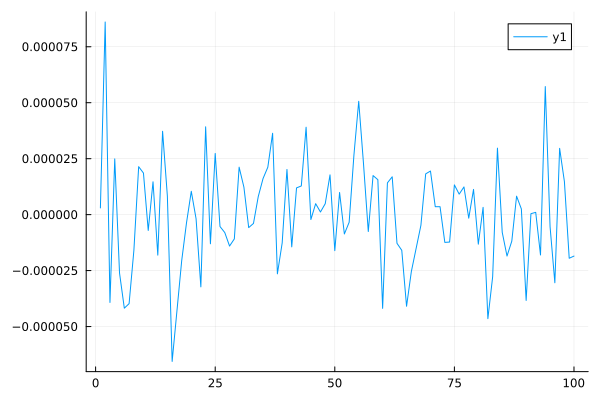

In [13]:
plot(X_train[1,:])